# Express sklearn pipeline as codeflare pipeline
Reference: https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_classification.html#sphx-glr-auto-examples-neighbors-plot-nca-classification-py

In [1]:
%matplotlib inline


# Comparing Nearest Neighbors with and without Neighborhood Components Analysis

An example comparing nearest neighbors classification with and without
Neighborhood Components Analysis.

It will plot the class decision boundaries given by a Nearest Neighbors
classifier when using the Euclidean distance on the original features, versus
using the Euclidean distance after the transformation learned by Neighborhood
Components Analysis. The latter aims to find a linear transformation that
maximises the (stochastic) nearest neighbor classification accuracy on the
training set.


Automatically created module for IPython interactive environment


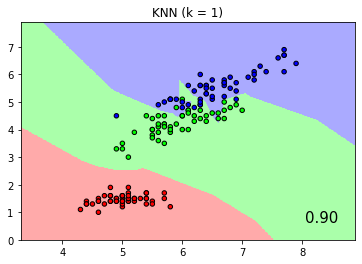

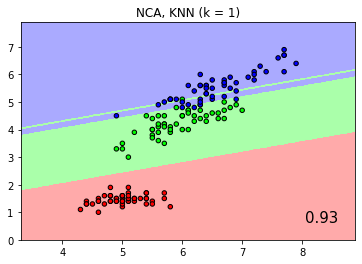

In [2]:
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline


print(__doc__)

n_neighbors = 1

dataset = datasets.load_iris()
X, y = dataset.data, dataset.target

# we only take two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = X[:, [0, 2]]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=0.7, random_state=42)

h = .01  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

names = ['KNN', 'NCA, KNN']

classifiers = [Pipeline([('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
                         ]),
               Pipeline([('scaler', StandardScaler()),
                         ('nca', NeighborhoodComponentsAnalysis()),
                         ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
                         ])
               ]

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

for name, clf in zip(names, classifiers):

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.rcParams['pcolor.shading'] ='nearest'
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=.8)

    # Plot also the training and testing points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("{} (k = {})".format(name, n_neighbors))
    plt.text(0.9, 0.1, '{:.2f}'.format(score), size=15,
             ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

2021-07-22 17:14:51,530	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8266


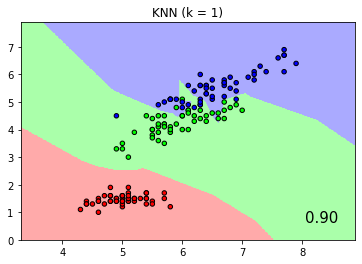

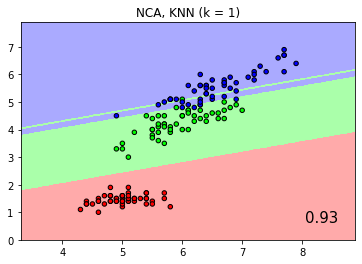

In [3]:
import ray
import codeflare.pipelines.Datamodel as dm
import codeflare.pipelines.Runtime as rt
from codeflare.pipelines.Datamodel import Xy
from codeflare.pipelines.Datamodel import XYRef
from codeflare.pipelines.Runtime import ExecutionType

ray.shutdown()
ray.init()

n_neighbors = 1

dataset = datasets.load_iris()
X, y = dataset.data, dataset.target

# we only take two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = X[:, [0, 2]]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=0.7, random_state=42)

h = .01  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

names = ['KNN', 'NCA, KNN']

pipeline = dm.Pipeline()
node_scalar = dm.EstimatorNode('scaler', StandardScaler())
node_knn = dm.EstimatorNode('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
node_nca = dm.EstimatorNode('nca', NeighborhoodComponentsAnalysis())
node_knn_post_nca = dm.EstimatorNode('knn_post_nca', KNeighborsClassifier(n_neighbors=n_neighbors))
pipeline.add_edge(node_scalar, node_knn)
pipeline.add_edge(node_scalar, node_nca)
pipeline.add_edge(node_nca, node_knn_post_nca)

# create training input
train_input = dm.PipelineInput()
train_input.add_xy_arg(node_scalar, dm.Xy(X_train, y_train))

pipeline_fitted = rt.execute_pipeline(pipeline, ExecutionType.FIT, train_input)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

name = names[0]
# create test input
test_input = dm.PipelineInput()
test_input.add_xy_arg(node_scalar, dm.Xy(X_test, y_test))

knn_pipeline = rt.select_pipeline(pipeline_fitted, pipeline_fitted.get_xyrefs(node_knn)[0])
knn_score = ray.get(rt.execute_pipeline(knn_pipeline, ExecutionType.SCORE, test_input)
                    .get_xyrefs(node_knn)[0].get_yref())

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
# create predict input
meshinput = np.c_[xx.ravel(), yy.ravel()]
meshlabel = np.ones(meshinput.shape[0]).shape
predict_input = dm.PipelineInput()
predict_input.add_xy_arg(node_scalar, dm.Xy(meshinput, meshlabel))

Z = ray.get(rt.execute_pipeline(knn_pipeline, ExecutionType.PREDICT, predict_input)
                         .get_xyrefs(node_knn)[0].get_yref())

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.rcParams['pcolor.shading'] ='nearest'
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=.8)

# Plot also the training and testing points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("{} (k = {})".format(name, n_neighbors))
plt.text(0.9, 0.1, '{:.2f}'.format(knn_score), size=15,
         ha='center', va='center', transform=plt.gca().transAxes)

name = names[1]
nca_pipeline = rt.select_pipeline(pipeline_fitted, pipeline_fitted.get_xyrefs(node_knn_post_nca)[0])
nca_score = ray.get(rt.execute_pipeline(nca_pipeline, ExecutionType.SCORE, test_input)
                    .get_xyrefs(node_knn_post_nca)[0].get_yref())

Z = ray.get(rt.execute_pipeline(nca_pipeline, ExecutionType.PREDICT, predict_input)
                         .get_xyrefs(node_knn_post_nca)[0].get_yref())

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=.8)

# Plot also the training and testing points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("{} (k = {})".format(name, n_neighbors))
plt.text(0.9, 0.1, '{:.2f}'.format(nca_score), size=15,
         ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

ray.shutdown()